**This is a tutorial of how easy it is to create images using freely available pretrained Generative Adversarial Networks (GANs)**

We're going to use Tensorflow Hub to load a pretrained BigGAN image generator network and produce some images with it.

**After you've read, run, and understood the code, try to modify it as follows:**
* Easy: Create images that blend two image classes. Remember that the y vector defines a probability distribution. Usually, you set the desired image class probability to 1 (e.g., "dog", the line ```y[:,229]=1``` in the code), and others to zero. However, if you want to blend objects, you can use non-zero values for multiple classes.  
* Slightly harder: Once you manage to create a good image, generate small variations of it
* Slightly harder: Interpolate between two images from different two classes. This can be done by interpolating between pairs of z and y vectors. If you've never done this, see here: https://gamedev.stackexchange.com/questions/18615/how-do-i-linearly-interpolate-between-two-vectors
* Advanced: load some target image, e.g., your own face. Define the module inputs as Tensorflow variables and optimize the variables to maximize the similarity between the generator output and the target image. This is somewhat similar to the [adversarial MNIST tutorial](AdversarialMNIST.ipynb). In other words, find the latent space coordinates that make the generator generate an image of you. Once you know the coordinates, you can try interpolating between you and some other images. (No model solution provided for this yet!). 

Model solutions are provided in the same folder, but first try to solve the problem yourself, at least for a few minutes. *Think of this as a puzzle game with optional hints that you will check only if you have to.*

As usual, we begin by importing everything we need. In addition to the usual suspects, we also include Tensorflow Hub, which is a service that allows loading some high-quality pretrained Tensorflow networks. 

Note that for some reason, my Jupyter gives me an error if I use GPU, even though I can run the same code from the command line. This is why I'm disabling the GPU. You might want to try removing that line.

In [ ]:
#The pylab inline may be needed to make figures visible in Jupyter, depending on your Anaconda installation
%pylab inline
#The following magic tells Colab to use Tensorflow 1 instead of Tensorflow 2. 
#Remove it if running this notebook outside Colab
%tensorflow_version 1.x

import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # comment this out if your tensorflow works ok with GPU
import tensorflow as tf
import tensorflow_hub as hub

Next, we load the BigGAN network module from Tensorflow Hub. We also print out some information about the inputs and outputs. We should see that the module wants z, y, and truncation inputs, and outputs a 'default' output. The shape of the output hints that this network generates a batch of 128x128 pixel images with 3 channels (RGB).

NOTE: this step may take about half a minute or more.

In [2]:
# Define the BigGAN model. The "128" means a 128x128 pixel model which is reasonably fast
# to run without a beefy GPU. There are also 256x256 and 512x512 models available
# Uncomment the one you want to test.
print("Loading BigGAN module")
module = hub.Module('https://tfhub.dev/deepmind/biggan-deep-128/1')
print("Module input info:")
print(module.get_input_info_dict())
print("Module output info:")
print(module.get_output_info_dict())


Loading BigGAN module
Module input info:
{'z': <hub.ParsedTensorInfo shape=(?, 128) dtype=float32 is_sparse=False>, 'y': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>, 'truncation': <hub.ParsedTensorInfo shape=() dtype=float32 is_sparse=False>}
Module output info:
{'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>}


To be able to generate images, we need to add a few more Tensorflow ops and create and initialize a Tensorflow Session.

NOTE: this step may take about half a minute or more.

In [4]:
print("Creating the sampling ops")
# The generator needs two inputs: random noise (z) and ImageNet class label (y).
# We define placeholders for these, which will make it easy to do experiments after 
# everything has been initialized
yIn=tf.placeholder(dtype=tf.float32,shape=[None,1000])  #there are 1000 classes
zIn=tf.placeholder(dtype=tf.float32,shape=[None,128]) #these deep BigGAN models have as many latent dimensions as pixel width and height
truncationIn=tf.placeholder(dtype=tf.float32)#this is just a sincle floating point number

# This tensor will hold the samples
samples = module(dict(y=yIn, z=zIn, truncation=truncationIn))

# As always, we need to have a Tensorflow session and initialize the variables.
print("Creating the session")
sess=tf.Session()
print("Initializing variables")
tf.global_variables_initializer().run(session=sess)
print("Done! You should now be able to generate samples.")

Creating the sampling ops
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0416 11:25:09.379369  6840 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Creating the session
Initializing variables
Done! You should now be able to generate samples.


Now that everything has been initialized, the actual image generation should be reasonably fast. We only need to feed the network new z and y values to get new images. 

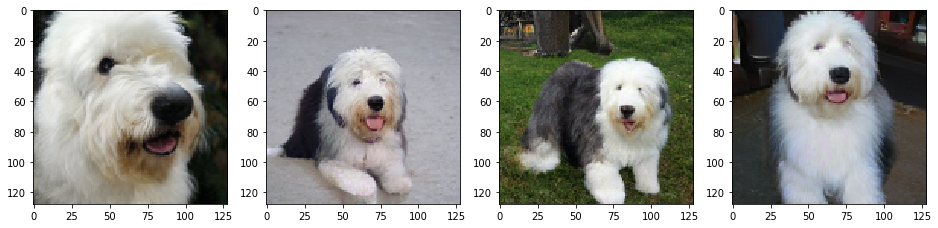

In [5]:
# We want this many images at a time
batch_size = 4

# First, let's define the labels. The labels are vectors of 1000 elements, each element in the range 0...1,
# representing the probability of an image class. Usually, we the generator a one-hot vector,
# where only one element is nonzero. 
# 229 means an Old English sheepdog, as defined here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
y=np.zeros([batch_size,1000]) #first create a batch of zeros
y[:,229]=1 #set the one-hot class of each batch item to 229

# Define how much variety we get. 
truncation = 0.5    

# Now let's define the image variant: this is a N-dimensional vector that
# defines a position in the generator's "latent space"
N=128 #these deep BigGAN models have as many latent dimensions as pixel width and height
z = truncation*np.random.normal(size=[batch_size, N])  # random vector

#Run the network, feeding the values computed above to the placeholder input tensors.
#According to the tutorial at Tensorflow Hub, the BigGAN module wants the 
#truncation also as a parameter for the compute graph, even though we already scaled the random vectors above using it.
samples_fetched=sess.run(samples,feed_dict={zIn:z,yIn:y,truncationIn:truncation})

#We will view multiple images on a row: initialize the figure
pp.figure(1,figsize=[batch_size*4,4])
for i in range(batch_size):
    #This subplot() call creates a grid with 1 rows and batch_size columns.
    #It also makes the following imshow() update the i:th image.
    pp.subplot(1,batch_size,1+i)
    #Apparently, the network's output is in the range -1...1. 
    #Thus, we remap to 0...1 to get correct colors with imshow()
    pp.imshow(samples_fetched[i]*0.5+0.5)